----PRE-FIT PARAMETERS ESTIMATION----
f0[Hz] = 3566.60
FWHM [Hz] = 0.40
Qt = 4.109E+02
IL[dB] = 29.63
Qe = 4.307E+02
A = 5.636E+01
----FIT RESULTS----
f0[Hz] = 3.566437E+03
Qt = 5.922E+02
Qe = 7.357E+02
Qi = 3.035E+03
A = 5.631E+01


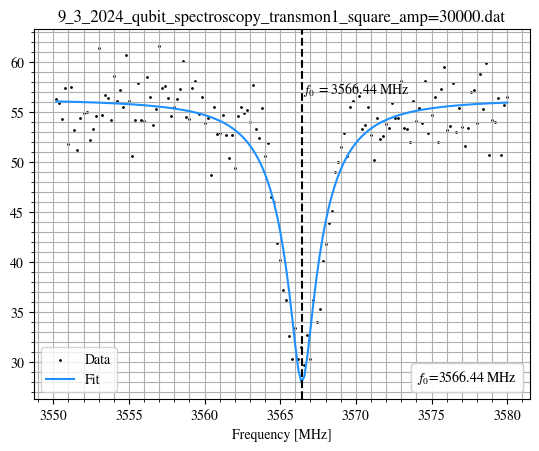

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.formatter.useoffset'] = False

def ResonatorHanger(fr, f0, Qt, Qe, A):
    S21power = (1-Qt/Qe/(1+4*Qt**2*(fr/f0-1)**2))**2 + (2*Qt**2*(fr/f0-1)/Qe/(1+4*Qt**2*(fr/f0-1)**2))**2
    S21power = A + 20*np.log10(S21power)
    return S21power

def ResonatorHangerFitSilent(fr, S21_dB, PwrRange = None):
    peak = np.min(S21_dB)
    fr_peak = fr[np.argmin(S21_dB)]
    Prefactor = (S21_dB[0]+S21_dB[-1])/2
    fr_3dB = 2*np.abs(fr[np.argmin(np.abs(S21_dB-peak-3.01))]-fr_peak) #FWHM
    Qi = fr_peak/fr_3dB
    QtOverQe = 1- 10**((peak-Prefactor)/20)
    Qe = Qi*(1/QtOverQe-1)
    Qt = (1/Qe + 1/Qi)**-1
    #windowing
    if PwrRange == None :
        fr_wndw = fr
        S21_wndw = S21_dB
    else:
        peak_idx = np.argmin(S21_dB)
        Idx_width = np.abs(peak_idx-np.argmin(np.abs(S21_dB-Prefactor+PwrRange)))
        fr_wndw = fr[peak_idx-Idx_width:peak_idx+Idx_width]
        S21_wndw = S21_dB[peak_idx-Idx_width:peak_idx+Idx_width]
    #done windowing
    Initial = [fr_peak, Qt,Qe, Prefactor]
    popt, pcov = curve_fit(ResonatorHanger, fr_wndw, S21_wndw, p0=Initial)
    f0_fit = popt[0]
    Qt_fit = popt[1]
    Qe_fit = popt[2]
    A_fit = popt[3]
    Qi_fit = (1/Qt_fit-1/Qe_fit)**-1
    return f0_fit,Qt_fit,Qe_fit,Qi_fit, A_fit


def ResonatorHangerFit(fr, S21_dB, PwrRange = None):
    peak = np.min(S21_dB)
    fr_peak = fr[np.argmin(S21_dB)]
    Prefactor = (S21_dB[0]+S21_dB[-1])/2
    fr_3dB = 2*np.abs(fr[np.argmin(np.abs(S21_dB-peak-3.01))]-fr_peak) #FWHM
    Qi = fr_peak/fr_3dB
    QtOverQe = 1- 10**((peak-Prefactor)/20)
    Qe = Qi*(1/QtOverQe-1)
    Qt = (1/Qe + 1/Qi)**-1
    print('----PRE-FIT PARAMETERS ESTIMATION----')
    print('f0[Hz] = %.2f'% fr_peak)
    print('FWHM [Hz] = %.2f'% fr_3dB)
    print('Qt = %.3E'% Qt)
    print('IL[dB] = %.2f' % peak)
    print('Qe = %.3E'% Qe)
    print('A = %.3E'% Prefactor)
    #windowing
    if PwrRange == None :
        fr_wndw = fr
        S21_wndw = S21_dB
    else:
        peak_idx = np.argmin(S21_dB)
        Idx_width = np.abs(peak_idx-np.argmin(np.abs(S21_dB-Prefactor+PwrRange)))
        fr_wndw = fr[peak_idx-Idx_width:peak_idx+Idx_width]
        S21_wndw = S21_dB[peak_idx-Idx_width:peak_idx+Idx_width]
    #done windowing
    Initial = [fr_peak, Qt,Qe, Prefactor]
    popt, pcov = curve_fit(ResonatorHanger, fr_wndw, S21_wndw, p0=Initial, bounds = (np.array([0,0,0,-np.inf]),np.array([np.inf,np.inf,np.inf,np.inf])))
    f0_fit = popt[0]
    Qt_fit = popt[1]
    Qe_fit = popt[2]
    A_fit = popt[3]
    Qi_fit = (1/Qt_fit-1/Qe_fit)**-1
    print('----FIT RESULTS----')
    print('f0[Hz] = %.6E'% f0_fit)
    print('Qt = %.3E'% Qt_fit)
    print('Qe = %.3E' % Qe_fit)
    print('Qi = %.3E' % Qi_fit)
    print('A = %.3E' % A_fit)

    fig, ax1 = plt.subplots()#figsize=[11, 5])
    ax1.scatter(fr,S21_dB, label = 'Data', s=1, color='black')
    plt.plot(fr_wndw, ResonatorHanger(fr_wndw,f0_fit,Qt_fit,Qe_fit, A_fit), label='Fit', color='dodgerblue')

    plt.axvline(x=f0_fit, color='black', linestyle='--')
    plt.text(f0_fit, plt.ylim()[1] * 0.9, f'$f_0$ = {f0_fit:.2f} MHz', color='black')
    
    ax1.set_xlabel('Frequency [MHz]')
    #ax1.set_ylabel('???')
    ax1.grid(which='both')
    ax1.minorticks_on()
            
    # Create the first legend for 'Data' and 'Fit'
    handles1, labels1 = ax1.get_legend_handles_labels()
    legend1 = ax1.legend(handles1, labels1, loc='lower left')

    # Create the second legend for fit parameters
    fit_params_label = [f'$f_0$={f0_fit:.2f} MHz']
    legend2 = ax1.legend([plt.Line2D([0], [0], color='w', lw=0)] * len(fit_params_label), fit_params_label, loc='lower right', handlelength=0, handletextpad=0)
            
    # Add both legends to the plot
    ax1.add_artist(legend1)
    ax1.add_artist(legend2)
    ax1.set_title(f'{FileName}')
    #plt.savefig(f'{FileName}.png')
    plt.show()

FileName = '9_3_2024_qubit_spectroscopy_transmon1_square_amp=30000.dat'
data = np.loadtxt(FileName, delimiter=',')
fr = data[:, 0]
S21_dB = data[:, 1]

ResonatorHangerFit(fr, S21_dB, PwrRange = None)

